In [1171]:
from pathlib import Path
import os

# Detectamos la ruta donde está guardado este notebook
notebook_dir = Path().resolve()
print(f"Directorio actual del notebook:\n{notebook_dir}\n")

# Cambiamos el directorio de trabajo a esta misma ruta
os.chdir(notebook_dir)

# Confirmamos
print(f"Nuevo directorio de trabajo:\n{os.getcwd()}")


Directorio actual del notebook:
C:\Users\admin\Documents\Códigos Pytohn\UNIDAD 3

Nuevo directorio de trabajo:
C:\Users\admin\Documents\Códigos Pytohn\UNIDAD 3


In [1172]:
# === Librerías ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

# Configuración general
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid", palette="deep")

In [1173]:
# === Cargar base del TP2 ===

eph = pd.read_csv("eph_base.csv")

print("Base cargada correctamente.")
print("Filas y columnas:", eph.shape)
display(eph.head(3))


Base cargada correctamente.
Filas y columnas: (7340, 37)


,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03,horastrab,ix_tot
0,1.00,2005,125814,1,Varón,46,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,Obrero o empleado,NaN,"2,400.00",480.00,Sí,...un sólo empleo/ocupación/actividad?,"2,400.00","2,400.00",No,46 a 60 años,1.00,3.93,805.93,0,2116,2,4,2,2.00,10.00,"2,518,778.11","845,811.04",48.00,0.00,1,48.00,5.00
1,2.00,2005,125814,1,Mujer,32,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,NaN,Ama de casa,"2,400.00",480.00,NaN,NaN,0.00,0.00,NaN,30 a 45 años,0.77,3.93,805.93,0,1024,2,4,2,2.00,10.00,"2,518,778.11","845,811.04",0.00,0.00,2,0.00,5.00
2,3.00,2005,125814,1,Varón,14,Soltero,Obra social (incluye PAMI),Primaria Completa,Inactivo,NaN,Estudiante,"2,400.00",480.00,NaN,NaN,0.00,0.00,NaN,14 años,0.96,3.93,805.93,0,196,1,3,2,7.00,8.00,"2,518,778.11","845,811.04",0.00,0.00,3,0.00,5.00


In [1174]:
#Cheque de duplicados y faltantes
print("Duplicados:", eph.duplicated().sum())


print("\n Missings:\n", eph.isnull().sum()) # conteo
#print(auto.isnull().mean() * 100) # como porcentaje

Duplicados: 0

 Missings:
 componente              0
ano4                    0
codusu                  0
nro_hogar               0
Sexo                    0
ch06                    0
ch07                    0
ch08                   17
nivel_ed                0
estado                407
cat_ocup             4109
cat_inac             3278
itf                     0
ipcf                    0
pp07h                4796
pp03c                4526
p47t                    0
p21                     0
pp03g                4264
Edad                    0
adulto_equiv            0
ad_equiv_hogar          0
ingreso_necesario       0
pobre                   0
edad2                   0
ch10                    0
ch12                    0
ch13                    0
ch14                 3465
educ                  142
itf_2025                0
linea_pobreza           0
pp3e_tot             2333
pp3f_tot             2333
ch03                    0
horastrab              30
ix_tot                  0
dtype: int6

In [1175]:
### Arreglamos un filtro adicional que encontramos que nos había faltado en la limpieza del TP1


#Estado
def clasificar_estado(estado, ch06):
    if pd.isna(estado) and ch06 < 10:
        return "Menor de 10 años"
    return estado

eph["estado"] = eph.apply(
    lambda row: clasificar_estado(row["estado"], row["ch06"]),
    axis=1)


#cat_ocup
def completar_cat_ocup(cat_ocup, estado):
    if pd.isna(cat_ocup):
        if estado in ["Inactivo", "Menor de 10 años", "Desocupado"]:
            return "No ocupado"
    return cat_ocup

eph["cat_ocup"] = eph.apply(
    lambda row: completar_cat_ocup(row["cat_ocup"], row["estado"]),
    axis=1
)


In [1176]:

#dropeamos las filas con nan que son inconsistentes. son muy pocas observacions no afectan los resultados.

eph[["estado","ch08","educ","horastrab"]].isna().sum()

estado         1
ch08          17
educ         142
horastrab     30
dtype: int64

In [1177]:
eph = eph.dropna(
    subset=["estado", "ch08", "educ","horastrab"]
)

# A. Enfoque de validación

In [1179]:
#Simplificamos variables categóricas con muchas categorías de manera innecesaria y categorías innecesarias para predicción y nos quedamos 
#con las de interés

eph = eph[
    eph["ch08"] != "Ns./Nr."
]

eph["cobertura_medica"] = eph["ch08"].apply(
    lambda x: "no_tiene" if x == "No paga ni le descuentan" else "tiene"
)



cols = [
    "ano4",
    "componente",
    "codusu",
    "nro_hogar",
    "Sexo",        
    "ch06",
    "educ",
    "estado",
    "cat_ocup",      
    "pobre",
    "cobertura_medica"
]

eph_variables_seleccionadas = eph[cols]


In [1180]:
#Chequeamos de nuevo missings
print("\n Missings:\n", eph_variables_seleccionadas.isnull().sum()) # conteo

#Nuestras variables de interés no tienen missings


 Missings:
 ano4                0
componente          0
codusu              0
nro_hogar           0
Sexo                0
ch06                0
educ                0
estado              0
cat_ocup            0
pobre               0
cobertura_medica    0
dtype: int64


In [1181]:
#Vemos cuales variables eran categóricas

# Variables e información
#print(auto.dtypes)
print(eph_variables_seleccionadas.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7150 entries, 0 to 7339
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ano4              7150 non-null   int64  
 1   componente        7150 non-null   float64
 2   codusu            7150 non-null   object 
 3   nro_hogar         7150 non-null   int64  
 4   Sexo              7150 non-null   object 
 5   ch06              7150 non-null   int64  
 6   educ              7150 non-null   float64
 7   estado            7150 non-null   object 
 8   cat_ocup          7150 non-null   object 
 9   pobre             7150 non-null   int64  
 10  cobertura_medica  7150 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 670.3+ KB
None


In [1182]:
#Creamos dummies para las variables categóricas:

eph_con_dummies = pd.get_dummies(
    eph_variables_seleccionadas.drop(columns=["codusu"]),
    drop_first=True,
    dtype=int
)

eph_con_dummies["codusu"] = eph_variables_seleccionadas["codusu"]

eph_con_dummies.head()

,ano4,componente,nro_hogar,ch06,educ,pobre,Sexo_Varón,estado_Inactivo,estado_Menor de 10 años,estado_Ocupado,cat_ocup_No ocupado,cat_ocup_Obrero o empleado,cat_ocup_Patrón,cat_ocup_Trabajador familiar sin remuneración,cobertura_medica_tiene,codusu
0,2005,1.00,1,46,10.00,0,1,0,0,1,0,1,0,0,1,125814
1,2005,2.00,1,32,10.00,0,0,1,0,0,1,0,0,0,1,125814
2,2005,3.00,1,14,8.00,0,1,1,0,0,1,0,0,0,1,125814
3,2005,4.00,1,9,5.00,0,1,0,1,0,1,0,0,0,1,125814
4,2005,5.00,1,3,0.00,0,0,0,1,0,1,0,0,0,1,125814


In [1183]:
#Nos quedamos con las variables de interés para simplificar y evitar colinealidad

vars_seleccionadas = [
    "ch06",
    "Sexo_Varón",
    "educ",
    "estado_Ocupado",
    "cobertura_medica_tiene",
    "pobre"
]

eph_con_dummies = eph_con_dummies[vars_seleccionadas]

In [1184]:
# Guardo los vectores de variable dependiente y de variable independiente respectivamente:
y = eph_con_dummies['pobre']
X = eph_con_dummies.drop(columns=["pobre"])

# Agrego columna de 1s para el intercepto
X = sm.add_constant(X)

### 1. Test de medias

In [1186]:
#Test de medias

resultados = []
for col in X.columns:
    x = X[col].values.reshape(-1, 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=444, stratify=y)
    t_x = stats.ttest_ind(x_train.flatten(), x_test.flatten())
    resultados.append({
        'Variable': col,
        'N train': x_train.shape[0],
        'Mean train': x_train.mean(),
        'sd train': x_train.std(),
        'N test': x_test.shape[0],
        'Mean test': x_test.mean(),
        'sd test': x_test.std(),
        't-test': t_x.statistic,
        'p-value': t_x.pvalue
    })

estadisticos = pd.DataFrame(resultados)
estadisticos.to_excel('dif_medias_multiple.xlsx', index=False)
estadisticos

C:\Users\admin\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,Variable,N train,Mean train,sd train,N test,Mean test,sd test,t-test,p-value
0,const,5005,1.00,0.00,2145,1.00,0.00,NaN,NaN
1,ch06,5005,34.69,21.52,2145,34.49,21.58,0.36,0.72
2,Sexo_Varón,5005,0.49,0.50,2145,0.49,0.50,-0.23,0.82
3,educ,5005,9.53,5.65,2145,9.48,5.64,0.33,0.74
4,estado_Ocupado,5005,0.42,0.49,2145,0.42,0.49,0.26,0.80
5,cobertura_medica_tiene,5005,0.79,0.41,2145,0.79,0.41,-0.61,0.54


### 2. Separación en respondieron_2005 y respondieron_2025

In [1188]:
# Separar en dos dataframes según el año
respondieron_2005 = eph[eph['ano4'] == 2005].copy()
respondieron_2005.sample(3)

,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03,horastrab,ix_tot,cobertura_medica
2497,1.00,2005,143073,1,Varón,44,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,Obrero o empleado,NaN,"3,950.00",493.75,Sí,...un sólo empleo/ocupación/actividad?,"2,200.00","2,200.00",No,30 a 45 años,1.00,6.68,"1,369.87",0,1936,2,4,2,4.00,12.00,"4,145,488.98","1,437,663.55",40.00,0.00,1,40.00,8.00,tiene
702,1.00,2005,261256,1,Mujer,38,Separado o divorciado,Obra social (incluye PAMI),Secundaria Incompleta,Desocupado,Obrero o empleado,NaN,200.00,50.00,NaN,NaN,200.00,0.00,NaN,30 a 45 años,0.77,3.23,662.38,1,1444,1,4,2,1.00,9.00,"209,898.18","695,157.68",0.00,0.00,1,0.00,4.00,tiene
1641,1.00,2005,128521,1,Varón,47,Casado,Obra social (incluye PAMI),Primaria Completa,Ocupado,Obrero o empleado,NaN,"2,550.00","1,275.00",Sí,NaN,850.00,400.00,No,46 a 60 años,1.00,1.76,360.92,0,2209,2,1,1,NaN,1.00,"2,676,201.75","378,785.61",0.00,0.00,1,0.00,2.00,tiene


In [1189]:
respondieron_2025 = eph[eph['ano4'] == 2025].copy()
respondieron_2025.sample(3)

,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03,horastrab,ix_tot,cobertura_medica
3396,1.00,2025,TQRMNORRQHJMKSCDEIHJF00875821,1,Varón,63,Unido,Obra social (incluye PAMI),Secundaria Completa,Desocupado,Obrero o empleado,NaN,"1,200,000.00","300,000.00",NaN,NaN,0.00,0.00,NaN,61 a 75 años,0.83,3.42,"1,248,905.34",1,3969,2,4,1,NaN,13.00,"1,200,000.00","1,248,905.34",NaN,NaN,1,0.00,4.00,tiene
3243,2.00,2025,TQRMNOTQSHKLLNCDEOHCH00861403,1,Varón,72,Casado,Obra social (incluye PAMI),Superior Universitaria Completa,Ocupado,Cuenta propia,NaN,"2,000,000.00","1,000,000.00",NaN,...un sólo empleo/ocupación/actividad?,"1,000,000.00","1,000,000.00",No,61 a 75 años,0.83,1.50,"547,765.50",0,5184,2,6,1,NaN,16.00,"2,000,000.00","547,765.50",40.00,0.00,2,40.00,2.00,tiene
5652,3.00,2025,TQRMNOSWUHLOLQCDEFPCH00852529,1,Varón,12,Soltero,No paga ni le descuentan,Secundaria Incompleta,Inactivo,No ocupado,Estudiante,"243,000.00","81,000.00",NaN,NaN,0.00,0.00,NaN,12 años,0.85,2.38,"869,121.26",1,144,1,4,2,1.00,9.00,"243,000.00","869,121.26",NaN,NaN,3,0.00,3.00,no_tiene


# B. Modelo de Regresion Logística

### Armar X_2025, y_2025 y el train/test de respondieron_2025

In [1192]:
# Modelo de Regresión Logística – Preparación de datos (2025)

# Índices de quienes respondieron en 2025
idx_2025 = respondieron_2025.index

# Matriz de predictores: todas las columnas de eph_con_dummies salvo 'pobre'
X_2025 = eph_con_dummies.loc[idx_2025].drop(columns=["pobre"]).copy()

# Variable dependiente: pobreza (0/1)
y_2025 = eph_con_dummies.loc[idx_2025, "pobre"].copy()

print("Dimensión X_2025:", X_2025.shape)
print("Dimensión y_2025:", y_2025.shape)

# Train–test split estratificado (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_2025,
    y_2025,
    test_size=0.3,
    random_state=444,
    stratify=y_2025
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Proporción de pobres en train:", y_train.mean())
print("Proporción de pobres en test:", y_test.mean())


Dimensión X_2025: (4083, 5)
Dimensión y_2025: (4083,)
Tamaño X_train: (2858, 5)
Tamaño X_test: (1225, 5)
Proporción de pobres en train: 0.20153953813855843
Proporción de pobres en test: 0.2016326530612245


### Estimar el modelo Logit y construir la tabla (coef, error estándar, odds-ratio)

In [1194]:
# Estimación de la regresión logística (Logit) 

# Agregamos constante solo para el Logit
X_train_logit = sm.add_constant(X_train, prepend=True)
X_test_logit = sm.add_constant(X_test, prepend=True)

logit_model = sm.Logit(y_train, X_train_logit)
logit_results = logit_model.fit()

# Resumen estándar en pantalla
print(logit_results.summary())


Optimization terminated successfully.
         Current function value: 0.434747
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  pobre   No. Observations:                 2858
Model:                          Logit   Df Residuals:                     2852
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.1349
Time:                        19:28:42   Log-Likelihood:                -1242.5
converged:                       True   LL-Null:                       -1436.2
Covariance Type:            nonrobust   LLR p-value:                 1.506e-81
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.0984      0.157      6.986      0.000       0.790      

In [1195]:
# Tabla con coeficientes, errores estándar y odds-ratios ===

params = logit_results.params         # coeficientes
bse = logit_results.bse               # errores estándar
odds_ratios = np.exp(params)          # odds-ratios

tabla_logit = pd.DataFrame({
    "coeficiente": params,
    "error_estandar": bse,
    "odds_ratio": odds_ratios
})

tabla_logit


,coeficiente,error_estandar,odds_ratio
const,1.10,0.16,3.00
ch06,-0.01,0.00,0.99
Sexo_Varón,-0.27,0.10,0.76
educ,-0.05,0.01,0.95
estado_Ocupado,-0.66,0.12,0.52
cobertura_medica_tiene,-1.68,0.11,0.19


In [1196]:
tabla_logit.to_excel("resultados_logit_respondieron_2025.xlsx", index=True)


### Visualización: probabilidad predicha vs. una variable numérica

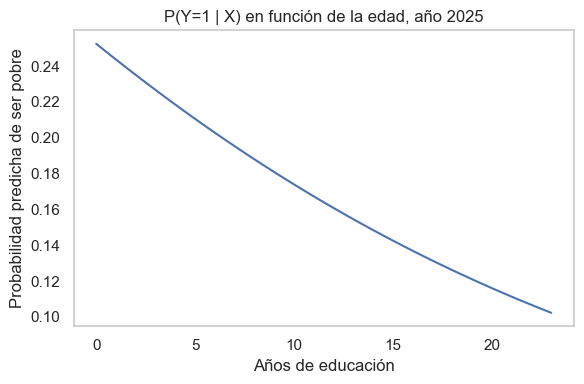

In [1198]:
# Visualización: P(Y=1|X) en función de educación (educ)  ===

import numpy as np
import matplotlib.pyplot as plt

# Rango de valores de edad en la muestra de entrenamiento
min_educ = X_train["educ"].min()
max_educ = X_train["educ"].max()

grid_educ = np.linspace(min_educ, max_educ, 50)

# Partimos de la media de X_train_logit (incluye la constante y todas las covariables)
X_base = X_train_logit.mean()

# Construimos una matriz con tantas filas como puntos en el grid
X_plot_logit = pd.DataFrame(
    [X_base.values] * len(grid_educ),
    columns=X_train_logit.columns
)

# Sustituimos la columna de edad por el grid
X_plot_logit["educ"] = grid_educ

# Predicción de probabilidades
p_hat = logit_results.predict(X_plot_logit)

# Gráfico
plt.figure(figsize=(6, 4))
plt.plot(grid_educ, p_hat)
plt.xlabel("Años de educación")
plt.ylabel("Probabilidad predicha de ser pobre")
plt.title("P(Y=1 | X) en función de la edad, año 2025")
plt.tight_layout()
plt.grid(False)
plt.savefig("probabilidad_pobreza_educacion_2025.png", dpi=300, bbox_inches='tight')
plt.show()


# C. Método de Vecinos Cercanos (KNN)

## 5. Estimación

In [1201]:
# Volvemos a hacer el muestreo

# Índices de quienes respondieron en 2025
idx_2025 = respondieron_2025.index

# Matriz de predictores: todas las columnas de eph_con_dummies salvo 'pobre'
X_2025 = eph_con_dummies.loc[idx_2025].drop(columns=["pobre"]).copy()

# Variable dependiente: pobreza (0/1)
y_2025 = eph_con_dummies.loc[idx_2025, "pobre"].copy()

print("Dimensión X_2025:", X_2025.shape)
print("Dimensión y_2025:", y_2025.shape)

# Train–test split estratificado (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_2025,
    y_2025,
    test_size=0.3,
    random_state=444,
    stratify=y_2025
)

Dimensión X_2025: (4083, 5)
Dimensión y_2025: (4083,)


In [1202]:
# Probamos con distintos tamaños de k (cantidad de vecinos)
k_range = [1,5,10]
scores = {}      # Para guardar la accuracy en un diccionario
scores_list = [] # Para guardar la accuracy en una lista
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        scores[k] = accuracy_score(y_test, y_pred_knn)
        scores_list.append(accuracy_score(y_test, y_pred_knn))

In [1203]:
tabla_scores = pd.DataFrame({
    "Vecinos (K)": list(scores.keys()),
    "Accuracy": list(scores.values())
})

tabla_scores

,Vecinos (K),Accuracy
0,1,0.74
1,5,0.78
2,10,0.79


## 6. Visualización

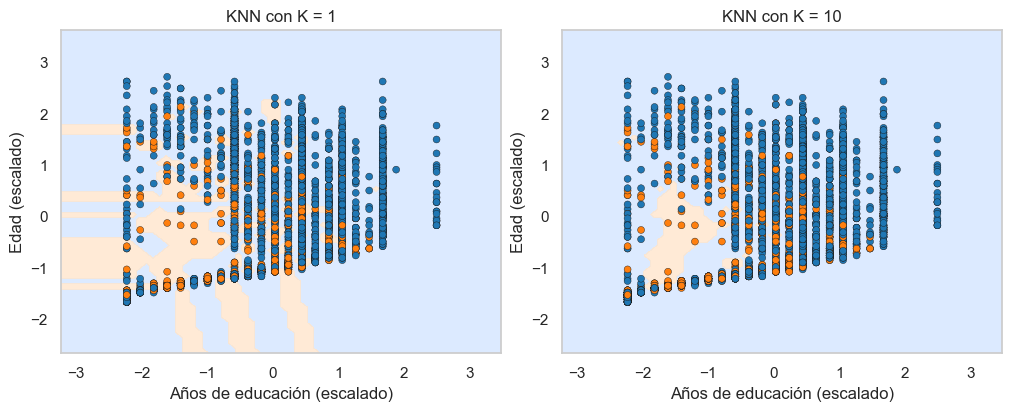

In [1205]:
from matplotlib.colors import ListedColormap

# Armar X, y

idx_2025 = respondieron_2025.index

cols = ["educ", "ch06"]       

X_arr = eph_con_dummies.loc[idx_2025, cols].to_numpy()
y_arr = eph_con_dummies.loc[idx_2025, "pobre"].to_numpy()

# Escalado 

scaler = StandardScaler().fit(X_arr)
X_scaled = scaler.transform(X_arr)

# Malla para pintar la frontera

h = 0.1  # paso de la grilla 
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

Ks = [1, 10]

fig, axes = plt.subplots(
    1, len(Ks),
    figsize=(5 * len(Ks), 4),
    constrained_layout=True
)

# Colores pastel azul y verde
cmap_bg = ListedColormap(["#d4e5ff", "#ffe5cc"])   # fondo
cmap_pts = ListedColormap(["#1f77b4", "#ff7f0e"])  # puntos

for ax, K in zip(axes, Ks):
    # Entrenar KNN
    knn = KNeighborsClassifier(n_neighbors=K, weights="uniform")
    knn.fit(X_scaled, y_arr)

    # Predicción sobre la malla
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Fondo con la frontera
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_bg, levels=[-0.5, 0.5, 1.5])

    # Puntos de entrenamiento 
    ax.scatter(
        X_scaled[:, 0],
        X_scaled[:, 1],
        c=y_arr,
        cmap=cmap_pts,
        s=25,
        edgecolor="k",
        linewidth=0.3
    )

    ax.set_title(f"KNN con K = {K}")
    ax.set_xlabel("Años de educación (escalado)")
    ax.set_ylabel("Edad (escalado)")
    ax.grid(False)  # sacar rejilla
plt.savefig("fronteras_knn_educ_edad.png", dpi=300, bbox_inches="tight")
plt.show()

### Selección de K óptimo con 5-fold Cross-Validation

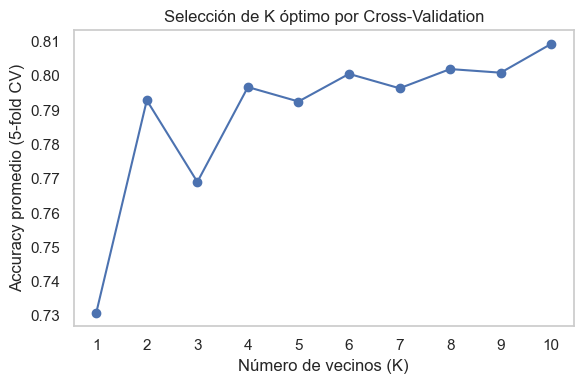

K óptimo según CV: 10


In [1207]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

# Rango de vecinos a evaluar
ks = range(1, 11)
accuracy_cv = []


# Validación cruzada a 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=444)

for k in ks:
    modelo_knn = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    
    # Validación cruzada dentro de X_train
    scores = cross_val_score(
        modelo_knn,
        X_train, y_train,
        cv=kf,
        scoring='accuracy'
    )
    
    accuracy_cv.append(scores.mean())

# --- Gráfico ---
plt.figure(figsize=(6,4))
plt.plot(ks, accuracy_cv, marker='o')
plt.xlabel("Número de vecinos (K)")
plt.ylabel("Accuracy promedio (5-fold CV)")
plt.title("Selección de K óptimo por Cross-Validation")
plt.xticks(ks)
plt.grid(False)
plt.tight_layout()
plt.savefig("seleccion de k optimo por cv.png", dpi=300, bbox_inches="tight")
plt.show()

# --- K óptimo ---
k_optimo = ks[np.argmax(accuracy_cv)]
print("K óptimo según CV:", k_optimo)

## D. Desempeño de modelos afuera de la muestra, métricas y políticas públicas

In [1209]:
#Volvemos a correr el logit para recuperar la variable


# Modelo de Regresión Logística – Preparación de datos (2025)

# Índices de quienes respondieron en 2025
idx_2025 = respondieron_2025.index

# Matriz de predictores: todas las columnas de eph_con_dummies salvo 'pobre'
X_2025 = eph_con_dummies.loc[idx_2025].drop(columns=["pobre"]).copy()

# Variable dependiente: pobreza (0/1)
y_2025 = eph_con_dummies.loc[idx_2025, "pobre"].copy()

# Train–test split estratificado (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_2025,
    y_2025,
    test_size=0.3,
    random_state=444,
    stratify=y_2025
)

# Estimación de la regresión logística (Logit)

# Agregamos constante solo para el Logit
X_train_logit = sm.add_constant(X_train, prepend=True)
X_test_logit = sm.add_constant(X_test, prepend=True)

logit_model = sm.Logit(y_train, X_train_logit)
logit_results = logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.434747
         Iterations 6


### Matriz de confusión del Logit (umbral p > 0.5)

In [1211]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score


# Predicciones de probabilidad con el modelo Logit
y_pred_prob_logit = logit_results.predict(X_test_logit)

# Umbral de clasificación
umbral = 0.5
y_pred_logit = (y_pred_prob_logit > umbral).astype(int)

# Matriz de confusión para Logit
cm_logit = confusion_matrix(y_test, y_pred_logit)

print("=== Matriz de confusión – Logit (umbral 0.5) ===")
print(cm_logit)


cm_df = pd.DataFrame(cm_logit,
                     index=["No pobre (Real)", "Pobre (Real)"],
                     columns=["No pobre (Pred)", "Pobre (Pred)"])

print("\nTabla de matriz de confusión:")
print(cm_df)

# exportar a Excel
cm_df.to_excel("matriz_confusion_logit.xlsx", index=True)


=== Matriz de confusión – Logit (umbral 0.5) ===
[[934  44]
 [189  58]]

Tabla de matriz de confusión:
                 No pobre (Pred)  Pobre (Pred)
No pobre (Real)              934            44
Pobre (Real)                 189            58


PermissionError: [Errno 13] Permission denied: 'matriz_confusion_logit.xlsx'

### Matriz de confusión KNN


In [ ]:
# Selección de K óptimo por Cross-Validation
ks = range(1, 11)
accuracy_cv = []
kf = KFold(n_splits=5, shuffle=True, random_state=444)

for k in ks:
    knn_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(knn_pipe, X_train, y_train, cv=kf, scoring="accuracy")
    accuracy_cv.append(scores.mean())

k_optimo = ks[np.argmax(accuracy_cv)]
print("K óptimo según CV:", k_optimo)


In [ ]:
# Entrenamos el KNN óptimo en el set de entrenamiento

modelo_knn_opt = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=k_optimo))
])
modelo_knn_opt.fit(X_train, y_train)

# Probabilidades predichas de pobreza en el test
y_pred_prob_knn = modelo_knn_opt.predict_proba(X_test)[:, 1]

# Para comparación, también matriz de confusión de KNN con umbral 0.5
y_pred_knn = (y_pred_prob_knn > 0.5).astype(int)
cm_knn = confusion_matrix(y_test, y_pred_knn)

print("\n=== Matriz de confusión – KNN (K óptimo, umbral 0.5) ===")
print(cm_knn)

cm_df = pd.DataFrame(cm_knn,
                     index=["No pobre (Real)", "Pobre (Real)"],
                     columns=["No pobre (Pred)", "Pobre (Pred)"])

print("\nTabla de matriz de confusión:")
print(cm_df)

# exportar a Excel
cm_df.to_excel("matriz_confusion_knn.xlsx", index=True)


### Curva ROC para ambos modelos

In [ ]:
# Curvas ROC para ambos modelos

# ROC Logit
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_prob_logit)
auc_logit = roc_auc_score(y_test, y_pred_prob_logit)

# ROC KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

plt.figure(figsize=(6, 4))
plt.plot(fpr_logit, tpr_logit, label=f"Logit (AUC = {auc_logit:.3f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (K={k_optimo}, AUC = {auc_knn:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Azar (AUC = 0.5)")
plt.xlabel("Especificidad (FPR)")
plt.ylabel("Sensibilidad (TPR)")
plt.title("Curvas ROC – Logit vs KNN (2025)")
plt.legend()
plt.grid(False) 
plt.tight_layout()
plt.savefig("curva ROC.png", dpi=300, bbox_inches="tight")
plt.show()


### Tabla con dos métricas de clasificación para ambos modelos

In [ ]:
# Tabla de métricas para Logit y KNN (K óptimo)

metricas_modelos = []

# Métricas para Logit
acc_logit = accuracy_score(y_test, y_pred_logit)
recall_logit = recall_score(y_test, y_pred_logit)  # asumiendo pobreza = 1

metricas_modelos.append({
    "Modelo": "Logit",
    "Accuracy": acc_logit,
    "Recall (pobre=1)": recall_logit
})

# Métricas para KNN
acc_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)

metricas_modelos.append({
    "Modelo": f"KNN (K={k_optimo})",
    "Accuracy": acc_knn,
    "Recall (pobre=1)": recall_knn
})

tabla_metricas = pd.DataFrame(metricas_modelos)
print("\n=== Métricas de desempeño en el test 2025 ===")
print(tabla_metricas)

tabla_metricas.to_excel("metricas_modelos_2025.xlsx", index=False)

## 9. El hacedor de política pública debe minimizar el error de tipo 2 en este caso, es decir, dejar a la menor cantidad de pobres sin alimentos (la menor cantidad de falsos negativos). En este caso, el modelo que mejor se comporta es el Logit, ya que tiene un mayor recall (TP/TP+FN) y la tasa de falsos negativos (1 - recall) es más baja.

## 10. Predicción de pobres en base sin respuesta de ingresos

In [ ]:
#Traigo la base norespondieron

eph_norespondieron = pd.read_csv("eph_norespondieron.csv")

eph_norespondieron.head(5)

### Es necesario crear las mismas variables que en respondieron tal como hicimos en el TP2

In [ ]:
#Vuelvo a cargar las EPH crudas para recuperar las nuevas variables solicitadsa: CH12, CH13 Y CH14

#EPH 2025 - La traigo directamente desde la web para ahorrar problema con rutas y llenado de memoria

url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1_Trim_2025_xls.zip"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Listar los archivos contenidos
    print(z.namelist())
    
    # Abrir el Excel
    with z.open("EPH_usu_1er_Trim_2025_xlsx/usu_individual_T125.xlsx") as f:
        eph_2025 = pd.read_excel(f)

eph_2025.columns = eph_2025.columns.str.lower()

In [ ]:
# Lo mismo para la EPH 2005
url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/t105_dta.zip"

# Descargar el ZIP
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Mostrar los archivos contenidos
    print(z.namelist())

    # Abrir el archivo .dta directamente desde el ZIP
    with z.open("Individual_t105.dta") as f:
        eph_2005 = pd.read_stata(f)

eph_2005.columns = eph_2005.columns.str.lower()

In [ ]:
#Tatamiento de codusu para poder hacer el merge posterior

def norm_key_str(s):
    return (s.astype(str)
             .str.normalize('NFKC')
             .str.replace('\u00a0',' ', regex=False)  # NBSP
             .str.replace(r'\.0$', '', regex=True)     # quita .0 final (p.ej., 125814.0)
             .str.strip())


eph_2005_control = eph_2005.copy()

# Normalizar
cols = ['codusu'] 
for c in cols:
    eph_2005_control[f'{c}_key'] = norm_key_str(eph_2005_control[c])

# Reemplazar las originales con las versiones *_key
for c in cols:
    eph_2005_control[c] = eph_2005_control[f'{c}_key']

# Eliminar las columnas *_key (ya no se necesitan)
eph_2005 = eph_2005_control.drop(columns=[f'{c}_key' for c in cols])

In [ ]:
# Pasamos las variables a numericas CH12, CH13 y CH14 para facilitar tratamiento.

def asistio(ch10):
    if ch10 == 'Sí, asiste':
        return 1
    elif ch10 == 'No asiste, pero asistió':
        return 2
    elif ch10 == 'Nunca asistió':
        return 3
    elif ch10 == 'Ns./Nr.':
        return 9
    else:
        return ch10

eph_2005['ch10'] = eph_2005['ch10'].apply(asistio)


def nivel(ch12):
    if ch12 == 'Jardín/Preescolar':
        return 0
    elif ch12 == 'Primario':
        return 1
    elif ch12 == 'EGB':
        return 3
    elif ch12 == 'Secundario':
        return 4
    elif ch12 == "Polimodal":
        return 5
    elif ch12 == "Terciario":
        return 6
    elif ch12 == "Universitario":
        return 7
    elif ch12 == 'Posgrado Universitario':
        return 8
    elif ch12 == 'Educación especial (discapacitado)':
        return 9
    else:
        return ch12

eph_2005['ch12'] = eph_2005['ch12'].apply(nivel)


def asistio(ch13):
    if ch13 == 'Sí':
        return 1
    elif ch13 == 'No':
        return 2
    elif ch13 == 'Ns./Nr.':
        return 9
    else:
        return ch13

eph_2005['ch13'] = eph_2005['ch13'].apply(asistio)


eph_2005['ch14'] = eph_2005['ch14'].astype(str).str.lstrip('0').replace('', '0')

eph_2005['ch10'] = pd.to_numeric(eph_2005['ch10'], errors='coerce').astype('Int64')
eph_2005['ch12'] = pd.to_numeric(eph_2005['ch12'], errors='coerce').astype('Int64')
eph_2005['ch13'] = pd.to_numeric(eph_2005['ch13'], errors='coerce').astype('Int64')
eph_2005['ch14'] = pd.to_numeric(eph_2005['ch14'], errors='coerce').astype('Int64')
eph_2005['componente'] = pd.to_numeric(eph_2005['componente'], errors='coerce').astype('Int64')
eph_2005['ano4'] = pd.to_numeric(eph_2005['ano4'], errors='coerce').astype('Int64')

In [ ]:
# Me traigo CH12, CH13 y CH14 de esas bases para depsues poder construir años de educación.

eph_2025.columns = eph_2025.columns.str.lower()
eph_2005.columns = eph_2005.columns.str.lower()


variables_interes = ['ano4', 'codusu', 'nro_hogar', 'componente','ch10','ch12', 'ch13', 'ch14']

eph_2025_sub = eph_2025[variables_interes]
eph_2005_sub = eph_2005[variables_interes]

eph_concatenado = (pd.concat([eph_2005_sub, eph_2025_sub], ignore_index=True))


eph = eph_norespondieron.merge(eph_concatenado, on=['ano4','codusu', 'nro_hogar', 'componente'], how='left')

eph.sample(10)

print(eph_2005[['ch10','ch12','ch13','ch14','componente','codusu','nro_hogar','ano4']].dtypes)
print(eph_2005[['ch10','ch12','ch13','ch14','componente','codusu','nro_hogar','ano4']].dtypes)

In [ ]:
# Una vez hecha la limpieza, creamos la variable educ
# Crea la variable 'educ' asignando años equivalentes de educación alcanzados
# según la combinación de nivel (ch12), situación educativa (ch13) y último año aprobado (ch14)
# a partir de las reglas definidas para cada tipo de enseñanza (primaria, secundaria, terciaria, etc.)

eph_norespondieron["educ"] = np.nan

# Lista de reglas
reglas = [
    # Casos base
    ((eph["ch10"] == 3) | (eph["ch06"] < 2) | (eph["ch12"] == 9), 0),

    # Jardín/preescolar
    ((eph["ch13"] == 2) & (eph["ch12"] == 1), 0),

    # Primaria
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 0), 1),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 1), 2),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 2), 3),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 3), 4),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 4), 5),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 5), 6),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 6), 7),

    # EGB
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 0), 1),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 1), 2),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 2), 3),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 3), 4),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 4), 5),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 5), 6),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 6), 7),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 7), 8),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 8), 9),

    # Secundaria
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 0), 8),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 1), 9),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 2), 10),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 3), 11),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 4), 12),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 5), 13),

    # Polimodal
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 0), 10),
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 1), 11),
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 2), 12),
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 3), 13),

    # Terciario
    ((eph["ch13"] == 2) & (eph["ch12"] == 6) & (eph["ch14"] == 0), 13),
    ((eph["ch13"] == 2) & (eph["ch12"] == 6) & (eph["ch14"] == 1), 14),
    ((eph["ch13"] == 2) & (eph["ch12"] == 6) & (eph["ch14"] >= 2) & (eph["ch14"] < 98), 15),

    # Universitario
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 0), 13),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 1), 14),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 2), 15),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 3), 16),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 4), 17),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] >= 5) & (eph["ch14"] < 98), 18),

    # Posgrado
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] == 0), 19),
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] == 1), 20),
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] == 2), 21),
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] >= 3) & (eph["ch14"] < 98), 22),

    # Completaron el nivel
    ((eph["ch13"] == 1) & (eph["ch12"] == 1), 1),
    ((eph["ch13"] == 1) & (eph["ch12"] == 2), 8),
    ((eph["ch13"] == 1) & (eph["ch12"] == 3), 11),
    ((eph["ch13"] == 1) & ((eph["ch12"] == 4) | (eph["ch12"] == 5)), 13),
    ((eph["ch13"] == 1) & (eph["ch12"] == 6), 16),
    ((eph["ch13"] == 1) & (eph["ch12"] == 7), 19),
    ((eph["ch13"] == 1) & (eph["ch12"] == 8), 23),
]

# Aplicar todas las reglas 
for condicion, valor in reglas:
    eph.loc[condicion, "educ"] = valor

In [ ]:
#Chequeamos que esté ok

eph[['nivel_ed','ch10','ch12','ch13','ch14','educ']].sample(15)

In [ ]:
#Cheuqueamos duplicados y missings en norepondieron
print("Duplicados:", eph.duplicated().sum())

print("\n Missings:\n", eph.isnull().sum()) # conteo

In [ ]:
### Hacemos las mismas limpiezas que hicimos en la primera parte

#Estado
def clasificar_estado(estado, ch06):
    if pd.isna(estado) and ch06 < 10:
        return "Menor de 10 años"
    return estado

eph["estado"] = eph.apply(
    lambda row: clasificar_estado(row["estado"], row["ch06"]),
    axis=1)


#cat_ocup
def completar_cat_ocup(cat_ocup, estado):
    if pd.isna(cat_ocup):
        if estado in ["Inactivo", "Menor de 10 años", "Desocupado"]:
            return "No ocupado"
    return cat_ocup

eph["cat_ocup"] = eph.apply(
    lambda row: completar_cat_ocup(row["cat_ocup"], row["estado"]),
    axis=1
)

eph = eph[
    eph["ch08"] != "Ns./Nr."
]

eph["cobertura_medica"] = eph["ch08"].apply(
    lambda x: "no_tiene" if x == "No paga ni le descuentan" else "tiene"
)

In [ ]:

#dropeamos las filas con nan que son inconsistentes. son muy pocas observacions no afectan los resultados.

eph[["estado","ch08","educ"]].isna().sum()

In [ ]:
eph = eph.dropna(
    subset=["estado", "ch08", "educ"]
)

In [ ]:
#Todas las variables de interés quedaron limpias
print("\n Missings:\n", eph.isnull().sum()) # conteo

In [ ]:
#Creamos dummies para las variables categóricas:

eph = eph.rename(columns={"ch04": "Sexo"})

cols = [
    "ano4",
    "componente",
    "codusu",
    "nro_hogar",
    "Sexo",        # corregido
    "ch06",
    "educ",
    "estado",
    "cat_ocup",    # corregido
    "ch10",
    "cobertura_medica"
]

eph_variables_seleccionadas = eph[cols]


eph_con_dummies = pd.get_dummies(
    eph_variables_seleccionadas.drop(columns=["codusu"]),
    drop_first=True,
    dtype=int
)

# Si querés volver a agregar codusu
eph_con_dummies["codusu"] = eph_variables_seleccionadas["codusu"]

eph_con_dummies.head()



vars_seleccionadas = [
    "ch06",
    "Sexo_Varón",
    "educ",
    "estado_Ocupado",
    "cobertura_medica_tiene",
]

eph_norespondieron = eph_con_dummies[vars_seleccionadas]

In [ ]:
#Resultado final

eph_norespondieron.head()

### Hacemos finalmente la estimación utilizando norespondieron

In [ ]:
#Agregamos constante
X_noresp_logit = sm.add_constant(eph_norespondieron, prepend=True)

#predecimos probabilidades de pobreza con el logit 
y_prob_noresp = logit_results.predict(X_noresp_logit)

#clasificar en pobres/no pobres según el umbral 
umbral = 0.5
y_pred_noresp = (y_prob_noresp > umbral).astype(int)

#Resultado
proporcion_pobres_noresp = y_pred_noresp.mean()
print("En porcentaje:", proporcion_pobres_noresp * 100, "%")